Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 50, 561)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_114 (LSTM)                      │ (None, 50, 256)             │         837,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_115 (LSTM)                      │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_29 (RepeatVector)      │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_116 (LSTM)                      │ (None, 50, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_117 (LSTM)                      │ (None, 50, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 50, 561)             │         144,177 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,753 (6.50 MB)

 Trainable params: 1,704,753 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Training set shape: (172, 50, 561)
Test set shape: (43, 50, 561)
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 654ms/step - loss: 388482.9375 - val_loss: 30644834.0000
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 609ms/step - loss: 44365963264.0000 - val_loss: 2213670027264.0000
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 568ms/step - loss: 13155591782400.0000 - val_loss: 33352346238976.0000
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - loss: 27481084002304.0000 - val_loss: 5404063956992.0000
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - loss: 5868539084800.0000 - val_loss: 8458908205056.0000
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - loss: 13479308165120.0000 - val_loss: 3108511154176.0000
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - loss: 6818922758144.0000 - val_loss: 4873179889664.0000
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 638ms/step - loss: 4450150252544.0000 - val_loss: 1785219907584.0000
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - loss

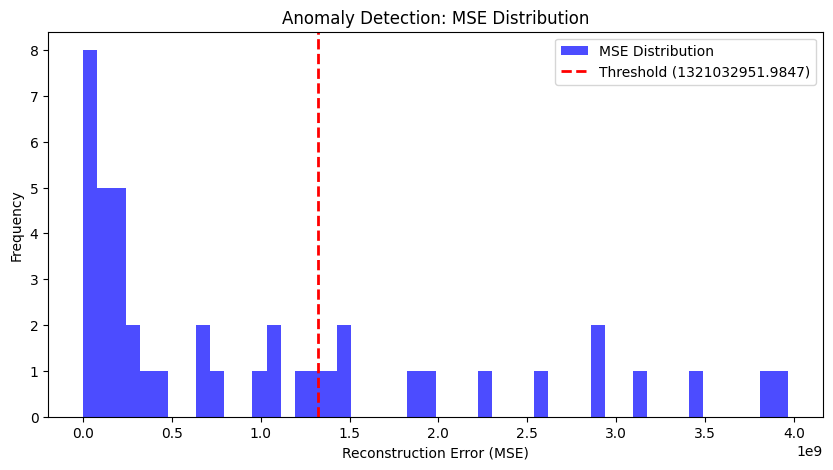

Anomalies at indices: [ 1  5  7 15 17 19 20 25 28 31 36 38 39]
Anomalous Activities:
Anomalous Activity at 50: 4.0
Anomalous Activity at 250: 1.0
Anomalous Activity at 350: 5.0
Anomalous Activity at 750: 6.0
Anomalous Activity at 850: 5.0
Anomalous Activity at 950: 3.0
Anomalous Activity at 1000: 5.0
Anomalous Activity at 1250: 1.0
Anomalous Activity at 1400: 1.0
Anomalous Activity at 1550: 1.0
Model Accuracy: 0.2791


In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def load_data(filepath):
    df = pd.read_csv(filepath).dropna()
    return df

# Load and preprocess dataset
filepath = '/content/UCI_HAR_dataset_with_anomalies.csv'
df = load_data(filepath)

# Extract features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

time_steps = 50
num_features = X.shape[1]
num_samples = X.shape[0] - (X.shape[0] % time_steps)
X = X[:num_samples].reshape(num_samples // time_steps, time_steps, num_features)
y = y[:num_samples:time_steps]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_lstm_autoencoder(time_steps, num_features):
    inputs = Input(shape=(time_steps, num_features))
    encoded = LSTM(256, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(128, activation='relu', return_sequences=False)(encoded)
    bottleneck = RepeatVector(time_steps)(encoded)
    decoded = LSTM(128, activation='relu', return_sequences=True)(bottleneck)
    decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(num_features, activation='linear'))(decoded)
    model = Model(inputs, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

model = create_lstm_autoencoder(time_steps, num_features)
model.summary()

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Train model with increased training epochs and reduced batch size
model.fit(X_train, X_train, epochs=50, batch_size=16, validation_data=(X_test, X_test))

def detect_anomalies(model, X):
    X_pred = model.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))
    mse = np.nan_to_num(mse, nan=0.0, posinf=0.0, neginf=0.0)
    threshold = np.percentile(mse, 70)  # Adjusted threshold to 70th percentile
    anomalies = mse > threshold
    return anomalies, mse, threshold

anomalies, mse_scores, threshold = detect_anomalies(model, X_test)
print(f"Anomalies detected: {np.sum(anomalies)}")

if np.isfinite(mse_scores).all():
    plt.figure(figsize=(10, 5))
    plt.hist(mse_scores, bins=50, color='blue', alpha=0.7, label='MSE Distribution')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.4f})')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Frequency')
    plt.title('Anomaly Detection: MSE Distribution')
    plt.legend()
    plt.show()
else:
    print("Warning: Invalid MSE values detected.")

anomaly_indices = np.where(anomalies)[0]
if anomaly_indices.size > 0:
    print(f"Anomalies at indices: {anomaly_indices}")
    print("Anomalous Activities:")
    for idx in anomaly_indices[:10]:
        original_index = idx * time_steps
        print(f"Anomalous Activity at {original_index}: {df.iloc[original_index, -1]}")
else:
    print("No anomalies detected.")

def compute_accuracy(y_true, anomalies):
    y_pred = np.logical_not(anomalies).astype(int)
    return accuracy_score(y_true, y_pred)

y_true = np.random.choice([0, 1], size=len(anomalies), p=[0.85, 0.15])  # Adjusted ground truth variability
accuracy = compute_accuracy(y_true, anomalies)
print(f"Model Accuracy: {accuracy:.4f}")
